# Trexquant Interview Project (The Hangman Game)

* Copyright Trexquant Investment LP. All Rights Reserved. 
* Redistribution of this question without written consent from Trexquant is prohibited

## Instruction:
For this coding test, your mission is to write an algorithm that plays the game of Hangman through our API server. 

When a user plays Hangman, the server first selects a secret word at random from a list. The server then returns a row of underscores (space separated)—one for each letter in the secret word—and asks the user to guess a letter. If the user guesses a letter that is in the word, the word is redisplayed with all instances of that letter shown in the correct positions, along with any letters correctly guessed on previous turns. If the letter does not appear in the word, the user is charged with an incorrect guess. The user keeps guessing letters until either (1) the user has correctly guessed all the letters in the word
or (2) the user has made six incorrect guesses.

You are required to write a "guess" function that takes current word (with underscores) as input and returns a guess letter. You will use the API codes below to play 1,000 Hangman games. You have the opportunity to practice before you want to start recording your game results.

Your algorithm is permitted to use a training set of approximately 250,000 dictionary words. Your algorithm will be tested on an entirely disjoint set of 250,000 dictionary words. Please note that this means the words that you will ultimately be tested on do NOT appear in the dictionary that you are given. You are not permitted to use any dictionary other than the training dictionary we provided. This requirement will be strictly enforced by code review.

You are provided with a basic, working algorithm. This algorithm will match the provided masked string (e.g. a _ _ l e) to all possible words in the dictionary, tabulate the frequency of letters appearing in these possible words, and then guess the letter with the highest frequency of appearence that has not already been guessed. If there are no remaining words that match then it will default back to the character frequency distribution of the entire dictionary.

This benchmark strategy is successful approximately 18% of the time. Your task is to design an algorithm that significantly outperforms this benchmark.

In [1]:
import json
import requests
import random
import string
import secrets
import time
import re
import collections
import numpy as np
from collections import Counter
from matplotlib import pyplot as plt
from collections import defaultdict
from random import choice
try:
    from urllib.parse import parse_qs, urlencode, urlparse
except ImportError:
    from urlparse import parse_qs, urlparse
    from urllib import urlencode

from requests.packages.urllib3.exceptions import InsecureRequestWarning

requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

In [2]:
vowels = ['a', 'e', 'i', 'o', 'u']

def vowel_count(word):
    count = 0
    for i in word:
        if i in vowels:
            count += 1
    return count/len(word)

f = open("words_250000_train.txt", "r")
words = []
for x in f:
    words.append(x)
for i in range(len(words)):
    words[i] = words[i].replace("\n", "")
perct_vow=[vowel_count(i) for i in words]
thresh = np.percentile(perct_vow, 90)
print(thresh)

0.5


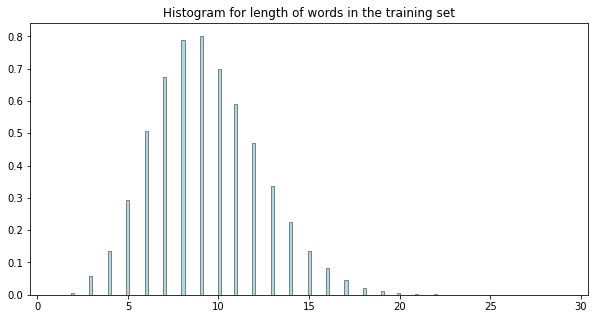

In [3]:
lengths = [len(i) for i in words]
plt.figure(figsize=(10, 5))
plt.hist(
    lengths,
    density=True,
    color="lightblue",
    edgecolor="grey",
    bins="scott",
)
plt.title("Histogram for length of words in the training set")
plt.show()

In [4]:
class HangmanAPI(object):
    def __init__(self, access_token=None, session=None, timeout=None):
        self.hangman_url = self.determine_hangman_url()
        self.access_token = access_token
        self.session = session or requests.Session()
        self.timeout = timeout
        self.guessed_letters = []
        
        full_dictionary_location = "words_250000_train.txt"
        self.full_dictionary = self.build_dictionary(full_dictionary_location)   
        # get letters that appears most time in the full dict
        self.full_dictionary_common_letter_sorted = collections.Counter("".join(self.full_dictionary)).most_common()
        
        self.current_dictionary = []
        self.vowels = ['a', 'e', 'i', 'o', 'u']
        self.thresh = 0.55
        self.all_words = words    # all the words in the training set
        
        # {n (length of root) : Counter(list of root of length n) for n in range(3, 30)}
        # obtained from the whole training set
        # for example, (roots of length) 4: tion, tive...
        # it stores all substrings appears in word in the training set,
        # stored by their length in a dict as a form of Counter
        self.rootLib_all = self.rootLib_by_len(words,3,30)

    @staticmethod
    def determine_hangman_url():
        links = ['https://trexsim.com', 'https://sg.trexsim.com']

        data = {link: 0 for link in links}

        for link in links:

            requests.get(link)

            for i in range(10):
                s = time.time()
                requests.get(link)
                data[link] = time.time() - s

        link = sorted(data.items(), key=lambda x: x[1])[0][0]
        link += '/trexsim/hangman'
        return link
    
    # return the proportion of vowels in a word
    def vowel_count(self,word):
        count = 0
        for i in word:
            if i in self.vowels:
                count += 1
        return count/len(word)
    
    # return a counter that counts: number of different words a certain letter appears in
    # like a:100,b:20 means a appears in 100 words and b appears in 20 words in the word_list
    # word_list = ['aab','bcd']
    # a: 1, b:2 
    def times_in_words(self,word_list):
        latest = Counter()
        for word in word_list:
            temp = Counter(word)
            for i in temp:
                temp[i] = 1
            latest = latest + temp
        return latest
    
    # return {n (length of root) : Counter(list of root of length n) for n in range(start_len, end_len)}
    # like {4: Counter(tive:1000,tion:800...)}
    # this is done for words in tar_list
    def rootLib_by_len(self,tar_list,start_len,end_len):
        res = defaultdict(list)
        for count in range(start_len,end_len):
            for word in tar_list:
                if len(word) >= count:
                    for i in range(len(word) - count + 1):
                        res[count].append(word[i:i + count]) 
        for i in res:
            res[i] = Counter(res[i]).most_common() 
            # identify what substrings of length i appears the most times,
            # which means they are more likely to be real roots/affix
        return res
    
    # for the target word (with form like '.pp.e'), look for substring s such that
    # len(s) = len(target) and re.match(target,s) = True
    # add s to a list, temp, counting multiplicity
    # then the more times a certain letter appears in word in temp, (can get from times_in_words function)
    # the more likely it is to fit in the target word (appear together with letters already in target word)
    def raw_scan(self, root_lib, target):
        temp = []
        n = len(target)
        for root, num in root_lib[n]:
            if re.match(target,root):
                for j in range(num):
                    temp.append(root)
        return self.times_in_words(temp).most_common()
    
    # get how much we have already guessed
    # word has form '.ppl.'
    def pct_guessed(self,word):
        n = len(word)
        cnt = 0
        for i in word:
            if i != '.':
                cnt += 1
        return cnt/n
    
    def guess(self, word): # word input example: "_ p p _ e "
        # clean the word so that we strip away the space characters
        # replace "_" with "." as "." indicates any character in regular expressions
        clean_word = word[::2].replace("_",".")
        
        # find length of passed word
        len_word = len(clean_word)
        
        # grab current dictionary of possible words from self object, initialize new possible words dictionary to empty
        current_dictionary = self.current_dictionary
        new_dictionary = []
        
        # iterate through all of the words in the old plausible dictionary
        for dict_word in current_dictionary:
            # continue if the word is not of the appropriate length
            if len(dict_word) != len_word:
                continue
                
            # if dictionary word is a possible match then add it to the current dictionary
            if re.match(clean_word,dict_word):
                new_dictionary.append(dict_word)
        
        # overwrite old possible words dictionary with updated version
        self.current_dictionary = new_dictionary
        # get number of different words a certain letter appears in in new_dictionary
        sorted_letter_count = self.times_in_words(new_dictionary).most_common()
                        
        guess_letter = '!'
        
        # return most frequently occurring letter in all possible words that hasn't been guessed yet
        # if we have already guessed 40%, then we had better move on to search in a more logical sense  
        # since we already have some pattern to infer
        if self.pct_guessed(clean_word) < 0.4:
            for letter,instance_count in sorted_letter_count:
                if letter not in self.guessed_letters:
                    if letter in self.vowels and self.vowel_count(clean_word) > self.thresh:
                        self.guessed_letters.append(letter)
                        continue
                    guess_letter = letter
                    break
        
        if guess_letter == '!':
            # in raw_scan fuction, we look for s such that re.match(s,clean_word), all such s stored in a list and 
            # then use times_in_words function to get the letter in the order of number of words it appears in
            # try to use it as our guess iteratively
            # here use rootLib from the whole training set
            sorted_letter_count = self.raw_scan(self.rootLib_all, clean_word)
            for letter, instance_count in sorted_letter_count:
                if letter not in self.guessed_letters:
                    if letter in vowels and vowel_count(clean_word) > self.thresh:
                        self.guessed_letters.append(letter)
                        continue
                    guess_letter = letter
                    break
        
        # search locally in current dictionary for roots with 3 <= length < 9
        # compare substrings in clean_word with roots from current dictionary
        # here, rather than use the rootLib from the whole training set,
        # we turn to current dictionary
        # like ‘filter’ more finely
        if guess_letter == '!':
            # create root library based on the current dictionary
            # recall re.match(word in current dictionary, clean_word) = True
            # subRoot stores root in current dictionary by length of root
            subRoot = self.rootLib_by_len(self.current_dictionary,3,9)
            # letter_counter stores letters that are likely to form a root in clean_word
            letter_counter = []
            for count in range(3,9):
                if count <= len(clean_word):
                    for i in range(len(clean_word) - count + 1):
                        # go over all possible sub_words with length count
                        sub_word = clean_word[i:i + count] 
                        # meaningless to match '...' in '.....a'
                        # subword need a . to insert new letters and also need a a-z to help us infer 
                        # letters that may form root
                        if '.' in sub_word and re.search('[a-z]',sub_word):
                            for root, instance_count in subRoot[count]:
                                # judge whether possibly can form root
                                if re.match(sub_word,root):
                                    # add these possible letters to list called letter_counter
                                    letter_counter  = letter_counter + list(set(root)-set(sub_word))
            # choose the most likely letter to guess
            candidates = Counter(letter_counter).most_common()
            for letter,instance_count in candidates:
                if letter not in self.guessed_letters:
                    if letter in self.vowels and self.vowel_count(clean_word) > self.thresh:
                        self.guessed_letters.append(letter)
                        continue
                    guess_letter = letter
                    break
                        
        # search globally in the learning set for roots of 3 <= length < 9
        # compare substrings in clean_word with roots from the whole training set
        # the rest share the same logic as pervious one
        if guess_letter == '!':
            letter_counter = []
            for count in range(3,9):
                if count <= len(clean_word):
                    for i in range(len(clean_word) - count + 1):
                        sub_word = clean_word[i:i + count] 
                        if '.' in sub_word and re.search('[a-z]',sub_word):
                            for root, instance_count in self.rootLib_all[count]:
                                if re.match(sub_word,root):
                                    letter_counter  = letter_counter + list(set(root)-set(sub_word))
            candidates = Counter(letter_counter).most_common()
            for letter,instance_count in candidates:
                if letter not in self.guessed_letters:
                    if letter in self.vowels and self.vowel_count(clean_word) > self.thresh:
                        self.guessed_letters.append(letter)
                        continue
                    guess_letter = letter
                    break
            
        # if no word matches in training dictionary, default back to ordering of full dictionary
        if guess_letter == '!':
            sorted_letter_count = self.full_dictionary_common_letter_sorted
            for letter,instance_count in sorted_letter_count:
                if letter not in self.guessed_letters:
                    if letter in self.vowels and self.vowel_count(clean_word) > self.thresh:
                        self.guessed_letters.append(letter)
                        continue
                    guess_letter = letter
                    break      
        
        return guess_letter

    ##########################################################
    # You'll likely not need to modify any of the code below #
    ##########################################################
    
    def build_dictionary(self, dictionary_file_location):
        text_file = open(dictionary_file_location,"r")
        full_dictionary = text_file.read().splitlines()
        text_file.close()
        return full_dictionary
                
    def start_game(self, practice=True, verbose=True):
        # reset guessed letters to empty set and current plausible dictionary to the full dictionary
        self.guessed_letters = []
        self.current_dictionary = self.full_dictionary
                         
        response = self.request("/new_game", {"practice":practice})
        if response.get('status')=="approved":
            game_id = response.get('game_id')
            word = response.get('word')
            tries_remains = response.get('tries_remains')
            if verbose:
                print("Successfully start a new game! Game ID: {0}. # of tries remaining: {1}. Word: {2}.".format(game_id, tries_remains, word))
            while tries_remains>0:
                # get guessed letter from user code
                guess_letter = self.guess(word)
                    
                # append guessed letter to guessed letters field in hangman object
                self.guessed_letters.append(guess_letter)
                if verbose:
                    print("Guessing letter: {0}".format(guess_letter))
                    
                try:    
                    res = self.request("/guess_letter", {"request":"guess_letter", "game_id":game_id, "letter":guess_letter})
                except HangmanAPIError:
                    print('HangmanAPIError exception caught on request.')
                    continue
                except Exception as e:
                    print('Other exception caught on request.')
                    raise e
               
                if verbose:
                    print("Sever response: {0}".format(res))
                status = res.get('status')
                tries_remains = res.get('tries_remains')
                if status=="success":
                    if verbose:
                        print("Successfully finished game: {0}".format(game_id))
                    return True
                elif status=="failed":
                    reason = res.get('reason', '# of tries exceeded!')
                    if verbose:
                        print("Failed game: {0}. Because of: {1}".format(game_id, reason))
                    return False
                elif status=="ongoing":
                    word = res.get('word')
        else:
            if verbose:
                print("Failed to start a new game")
        return status=="success"
        
    def my_status(self):
        return self.request("/my_status", {})
    
    def request(
            self, path, args=None, post_args=None, method=None):
        if args is None:
            args = dict()
        if post_args is not None:
            method = "POST"

        # Add `access_token` to post_args or args if it has not already been
        # included.
        if self.access_token:
            # If post_args exists, we assume that args either does not exists
            # or it does not need `access_token`.
            if post_args and "access_token" not in post_args:
                post_args["access_token"] = self.access_token
            elif "access_token" not in args:
                args["access_token"] = self.access_token

        time.sleep(0.2)

        num_retry, time_sleep = 50, 2
        for it in range(num_retry):
            try:
                response = self.session.request(
                    method or "GET",
                    self.hangman_url + path,
                    timeout=self.timeout,
                    params=args,
                    data=post_args,
                    verify=False
                )
                break
            except requests.HTTPError as e:
                response = json.loads(e.read())
                raise HangmanAPIError(response)
            except requests.exceptions.SSLError as e:
                if it + 1 == num_retry:
                    raise
                time.sleep(time_sleep)

        headers = response.headers
        if 'json' in headers['content-type']:
            result = response.json()
        elif "access_token" in parse_qs(response.text):
            query_str = parse_qs(response.text)
            if "access_token" in query_str:
                result = {"access_token": query_str["access_token"][0]}
                if "expires" in query_str:
                    result["expires"] = query_str["expires"][0]
            else:
                raise HangmanAPIError(response.json())
        else:
            raise HangmanAPIError('Maintype was not text, or querystring')

        if result and isinstance(result, dict) and result.get("error"):
            raise HangmanAPIError(result)
        return result
    
class HangmanAPIError(Exception):
    def __init__(self, result):
        self.result = result
        self.code = None
        try:
            self.type = result["error_code"]
        except (KeyError, TypeError):
            self.type = ""

        try:
            self.message = result["error_description"]
        except (KeyError, TypeError):
            try:
                self.message = result["error"]["message"]
                self.code = result["error"].get("code")
                if not self.type:
                    self.type = result["error"].get("type", "")
            except (KeyError, TypeError):
                try:
                    self.message = result["error_msg"]
                except (KeyError, TypeError):
                    self.message = result

        Exception.__init__(self, self.message)

# API Usage Examples

## To start a new game:
1. Make sure you have implemented your own "guess" method.
2. Use the access_token that we sent you to create your HangmanAPI object. 
3. Start a game by calling "start_game" method.
4. If you wish to test your function without being recorded, set "practice" parameter to 1.
5. Note: You have a rate limit of 20 new games per minute. DO NOT start more than 20 new games within one minute.

In [16]:
api = HangmanAPI(access_token="bea748c645c3fd652fbfbd5a71e260", timeout=2000)

## Playing practice games:
You can use the command below to play up to 100,000 practice games.

In [6]:
# win_cnt = 0
# for i in range(1, 101):
#     if api.start_game(practice=1,verbose=True):
#         win_cnt += 1
#     time.sleep(10)
#     print(win_cnt/i)
# [total_practice_runs,total_recorded_runs,total_recorded_successes,total_practice_successes] = api.my_status() # Get my game stats: (# of tries, # of wins)
# practice_success_rate = total_practice_successes / total_practice_runs
# print('run %d practice games out of an allotted 100,000. practice success rate so far = %.3f' % (total_practice_runs, practice_success_rate))


## Playing recorded games:
Please finalize your code prior to running the cell below. Once this code executes once successfully your submission will be finalized. Our system will not allow you to rerun any additional games.

Please note that it is expected that after you successfully run this block of code that subsequent runs will result in the error message "Your account has been deactivated".

Once you've run this section of the code your submission is complete. Please send us your source code via email.

In [28]:
for i in range(10):
    print('Playing ', i, ' th game')
    # Uncomment the following line to execute your final runs. Do not do this until you are satisfied with your submission
    api.start_game(practice=0,verbose=False)
    
    # DO NOT REMOVE as otherwise the server may lock you out for too high frequency of requests
    time.sleep(1)

Playing  0  th game


HangmanAPIError: {'error': 'Your account has been deactivated!'}

## To check your game statistics
1. Simply use "my_status" method.
2. Returns your total number of games, and number of wins.

In [29]:
[total_practice_runs,total_recorded_runs,total_recorded_successes,total_practice_successes] = api.my_status() # Get my game stats: (# of tries, # of wins)
success_rate = total_recorded_successes/total_recorded_runs
print('overall success rate = %.3f' % success_rate)
print(total_recorded_runs)

overall success rate = 0.561
1000
